# **CarND-Advanced-Lane-Lines** 
***


---

In [1]:
"""
Detecting line segments on single pictures and videos which have been made by a camera in a car. 
Programm: Udacity - Self Driving Car Engineer
Project: P4 - CarND-Advanced-Lane-Lines
Author: Daniel Gattringer (gada1982) 
"""

#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline



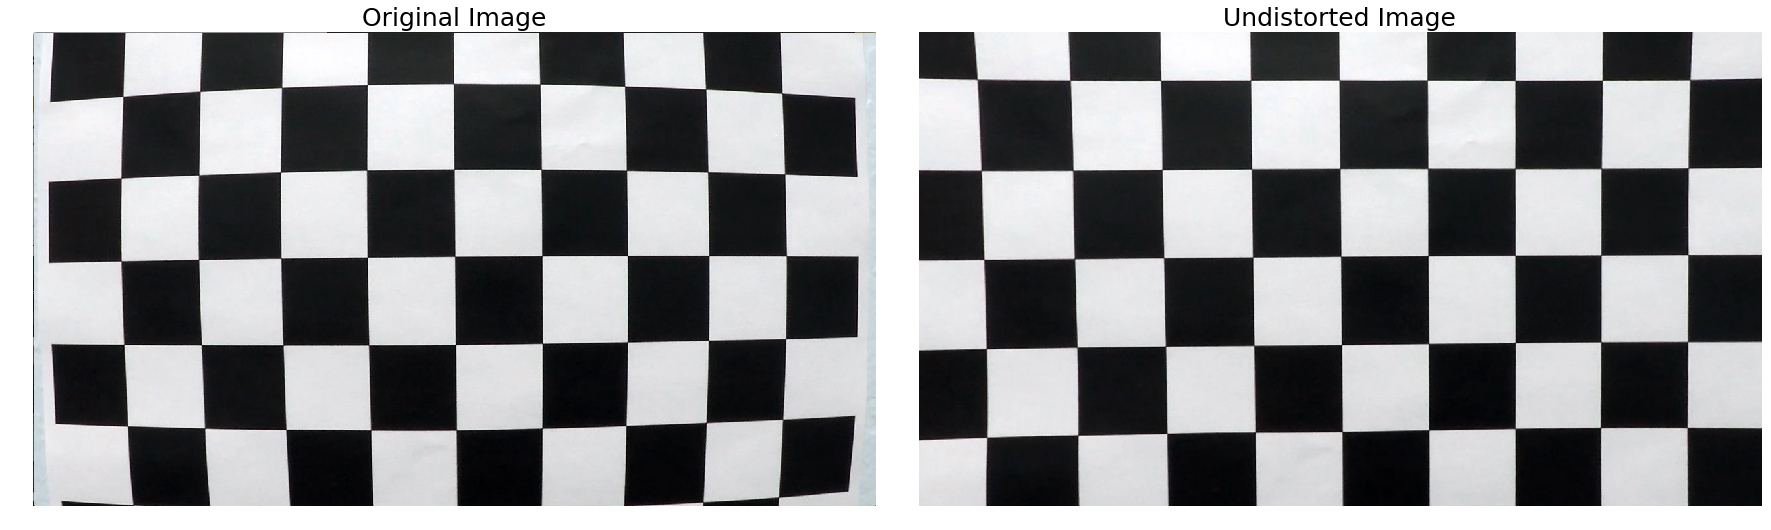

In [2]:
# Code taken from https://github.com/udacity/CarND-Camera-Calibration

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'camera_cal_corners_found/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)

# Read in an image
image = cv2.imread('camera_cal/calibration1.jpg')

def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

image_undist = cal_undistort(image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(image_undist)
ax2.set_title('Undistorted Image', fontsize=25)
ax2.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

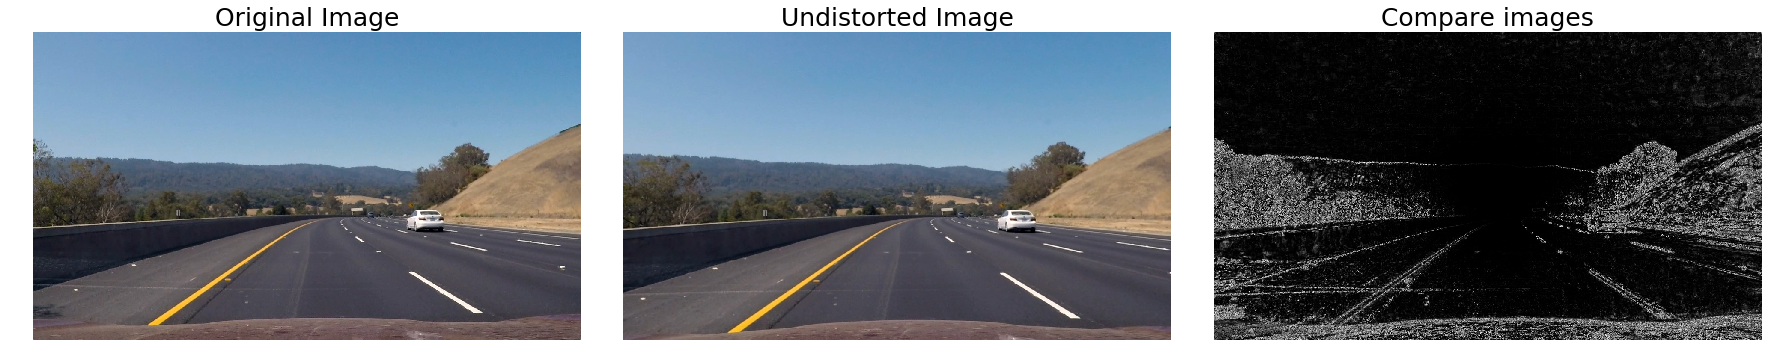

In [3]:
# Distort test_images

# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

image_undist = cal_undistort(image, objpoints, imgpoints)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(image_undist)
ax2.axis('off')
ax2.set_title('Undistorted Image', fontsize=25)
ax3.imshow(np.sum((image - image_undist)**2,axis=2),cmap='gray')
ax3.axis('off')
ax3.set_title('Compare images', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

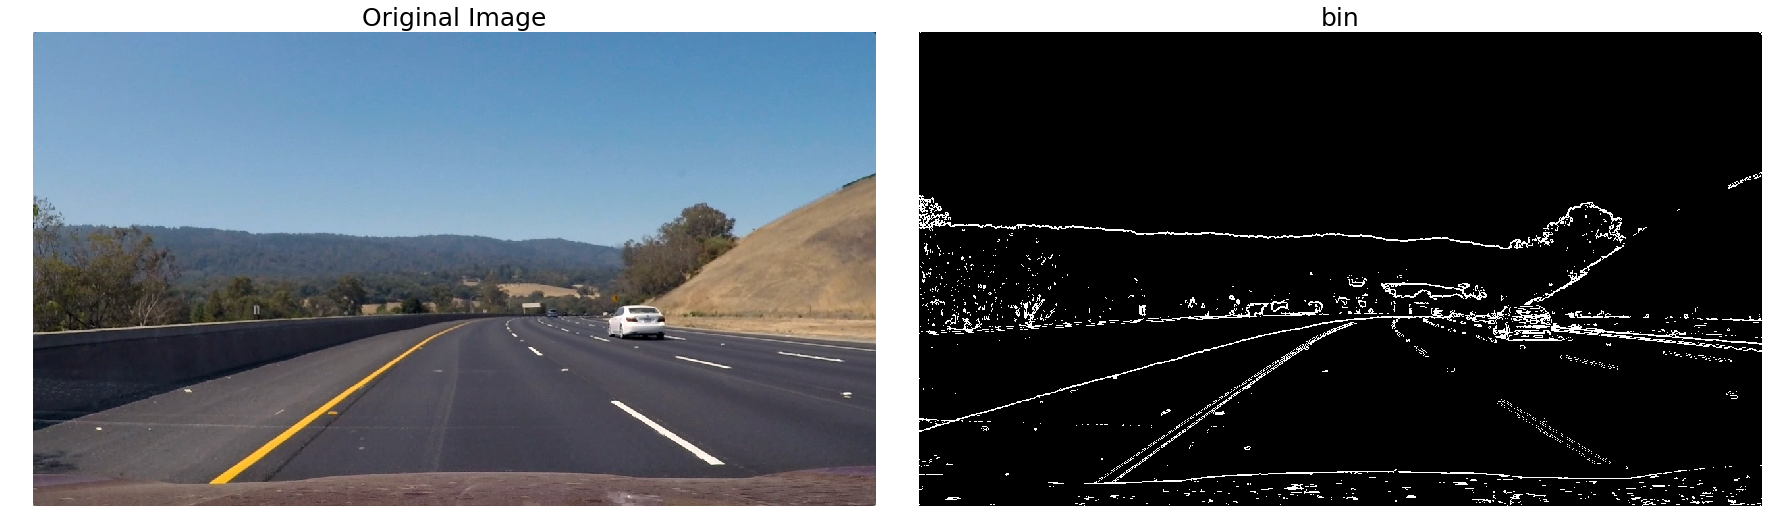

In [4]:
# Create a binary image for one image

def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Apply the following steps to img
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(image, sobel_kernel, mag_thresh):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)    
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel, thresh):
     # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(sobelx**2)
    abs_sobely = np.sqrt(sobely**2)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_sobel = np.arctan2(np.absolute(abs_sobely), np.absolute(abs_sobelx))
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary

# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

#combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(mag_binary, cmap='gray')
ax2.axis('off')
ax2.set_title('bin', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

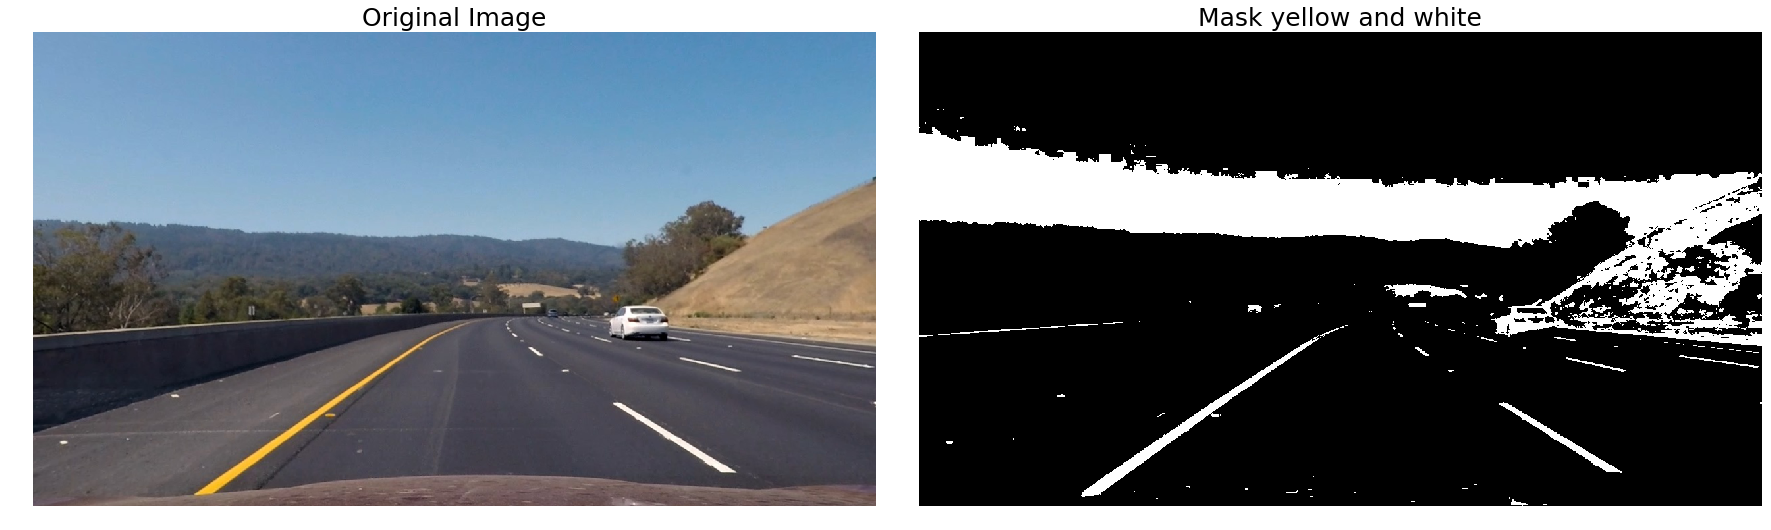

In [5]:
# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

# undistort image
image = cal_undistort(image, objpoints, imgpoints)

def get_color_mask(img):
    
    image_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    
    # White - TODO test different values
    hsv_white_l  = np.array([ 0,   0,   150])
    hsv_white_h = np.array([ 255,  90, 255])
    
    # Mask for white lanes
    mask_white = cv2.inRange(image_hsv, hsv_white_l, hsv_white_h)
    
    # Yellow - TODO test different values
    hsv_yellow_l  = np.array([ 0,  110,  110])
    hsv_yellow_h = np.array([ 90, 255, 255])
    
    # Mask for yellow lanes
    mask_yellow = cv2.inRange(image_hsv, hsv_yellow_l, hsv_yellow_h)
    
    mask_white_yellow = cv2.bitwise_or(mask_white, mask_yellow)
    
    return mask_white_yellow

mask_yellow_white = get_color_mask(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(mask_yellow_white, cmap='gray')
ax2.axis('off')
ax2.set_title('Mask yellow and white', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

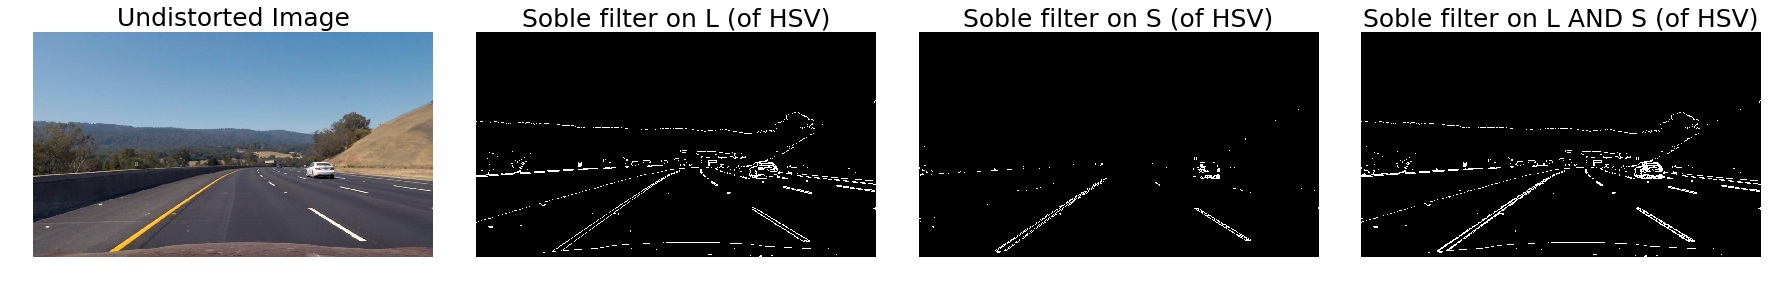

In [6]:
# Apply sobel filters
# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

# undistort image
image = cal_undistort(image, objpoints, imgpoints)

def get_sobel_mask(img):
    # Get image in HLS Color Space
    image_hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    
    # Get L channel
    image_hls_l = image_hls[:,:,1]
    ksize = 5
    thresh = (50,225)
    gradx = abs_sobel_thresh(image_hls_l, orient='x', sobel_kernel = ksize, thresh = thresh)
    grady = abs_sobel_thresh(image_hls_l, orient='y', sobel_kernel = ksize, thresh = thresh)
    
    filter_hls_l = np.copy(cv2.bitwise_or(gradx, grady))
    
    # Get S channel
    image_hls_s = image_hls[:,:,2]
    gradx = abs_sobel_thresh(image_hls_s, orient='x', sobel_kernel = ksize, thresh = thresh)
    grady = abs_sobel_thresh(image_hls_s, orient='y', sobel_kernel = ksize, thresh = thresh)
    
    filter_hls_s = np.copy(cv2.bitwise_or(gradx, grady))
    
    return filter_hls_l, filter_hls_s

filter_hls_l, filter_hls_s = get_sobel_mask(image)
filter_hls_l_s = cv2.bitwise_or(filter_hls_l,filter_hls_s)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 20))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(filter_hls_l, cmap='gray')
ax2.axis('off')
ax2.set_title('Soble filter on L (of HSV)', fontsize=25)
ax3.imshow(filter_hls_s, cmap='gray')
ax3.axis('off')
ax3.set_title('Soble filter on S (of HSV)', fontsize=25)
ax4.imshow(filter_hls_l_s, cmap='gray')
ax4.axis('off')
ax4.set_title('Soble filter on L AND S (of HSV)', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

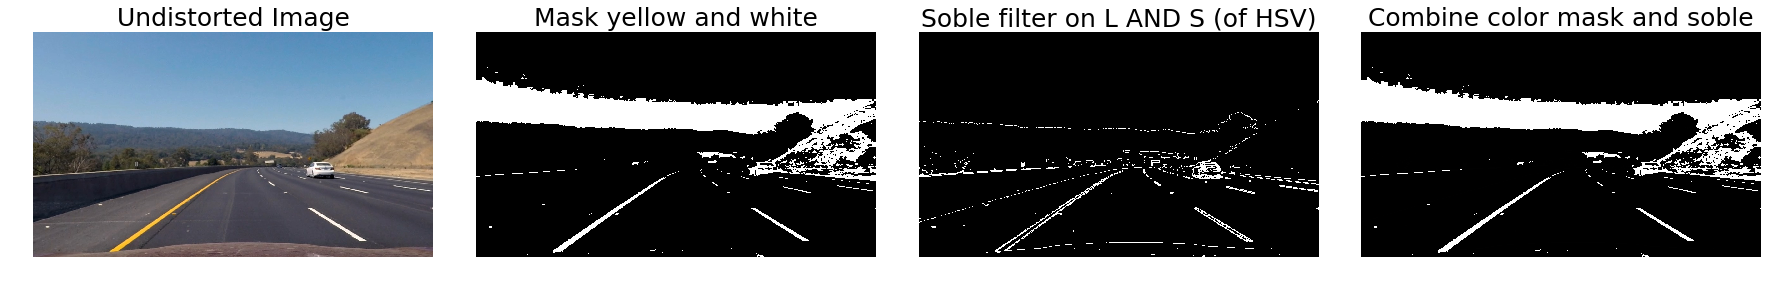

In [7]:
# Combine Color mask (white and yellow) and sobel filters
# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

# undistort image
image = cal_undistort(image, objpoints, imgpoints)

mask_yellow_white = get_color_mask(image)

filter_hls_l, filter_hls_s = get_sobel_mask(image)
filter_hls_l_s = cv2.bitwise_or(filter_hls_l,filter_hls_s)

image_filter_comb = cv2.bitwise_or(filter_hls_l_s, mask_yellow_white)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 20))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(mask_yellow_white, cmap='gray')
ax2.axis('off')
ax2.set_title('Mask yellow and white', fontsize=25)
ax3.imshow(filter_hls_l_s, cmap='gray')
ax3.axis('off')
ax3.set_title('Soble filter on L AND S (of HSV)', fontsize=25)
ax4.imshow(image_filter_comb, cmap='gray')
ax4.axis('off')
ax4.set_title('Combine color mask and soble', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


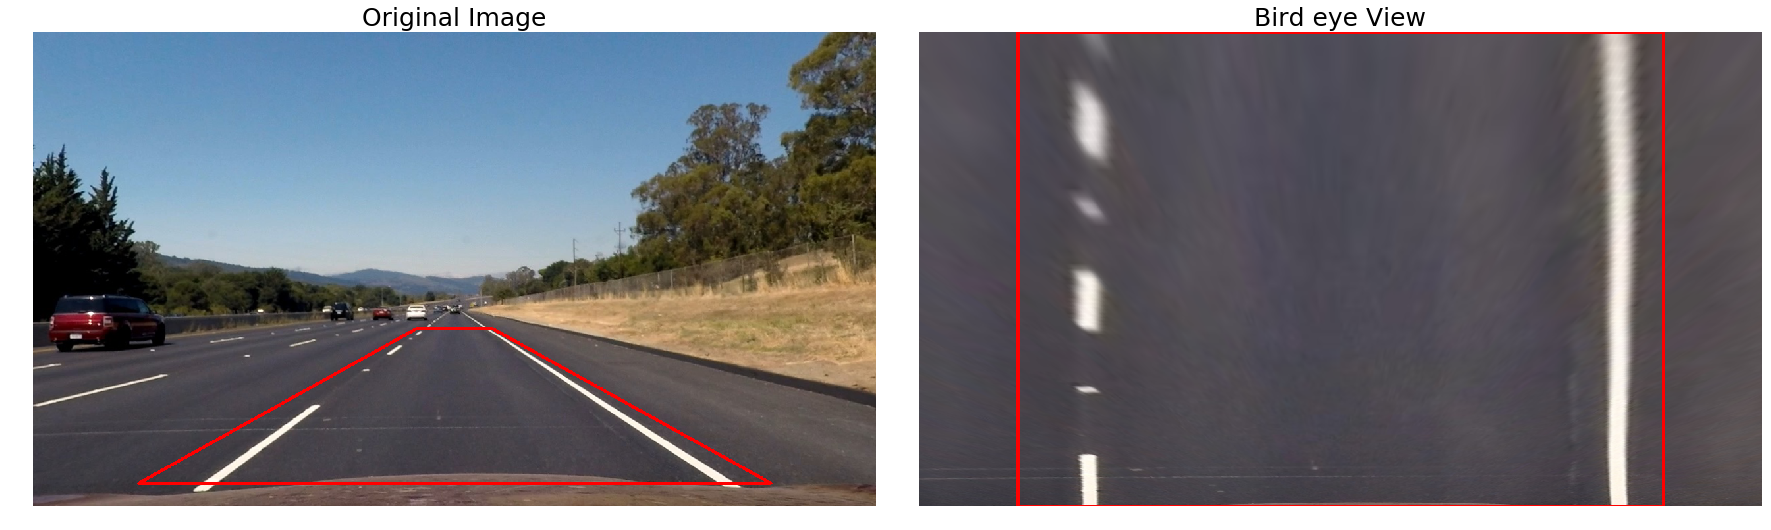

In [8]:
# Apply perspective transform to get Bird-Eye-View
# read in one test image 
image = mpimg.imread('test_images/straight_lines2.jpg')

# undistort image
image = cal_undistort(image, objpoints, imgpoints)

# Get the size of the image
image_size = np.shape(image)

mid_y_points = int(np.uint(image_size[0] / 1.6))
bottom_points = int(np.uint(image_size[0]) / 1.05)
center_image = int(np.uint(image_size[1]/2))
# TODO changenames
ctl_window = int(center_image - (image_size[1] / 2) * 0.09)
ctr_window = int(center_image + (image_size[1] / 2) * 0.09)
cbl_window = int(center_image - (image_size[1] / 2) * 0.75)
cbr_window = int(center_image + (image_size[1] / 2) * 0.75)

points_src = [[cbl_window,bottom_points],[cbr_window,bottom_points],[ctr_window,mid_y_points],[ctl_window,mid_y_points]]
points_dst = [[150,image_size[0]],[image_size[1]-150,image_size[0]],[image_size[1]-150,0],[150,0]]
points_src_float = np.float32(points_src)
points_dst_float = np.float32(points_dst)

points_src_arr = np.array(points_src)
points_dst_arr = np.array(points_dst)


def warp_image(image, points_src_float, points_dst_float):
    image_size = np.shape(image)
    image_size = (image_size[1],image_size[0])
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(points_src_float, points_dst_float)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(points_dst_float, points_src_float)

    return warped, M, Minv

warped, M_warp, M_inv_warp = warp_image(image, points_src_float, points_dst_float)
cv2.polylines(image, [points_src_arr], True, color = (255,0,0), thickness = 3)
cv2.polylines(warped, [points_dst_arr], True, color = (255,0,0), thickness = 3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)   
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped)
ax2.axis('off')
ax2.set_title('Bird eye View', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

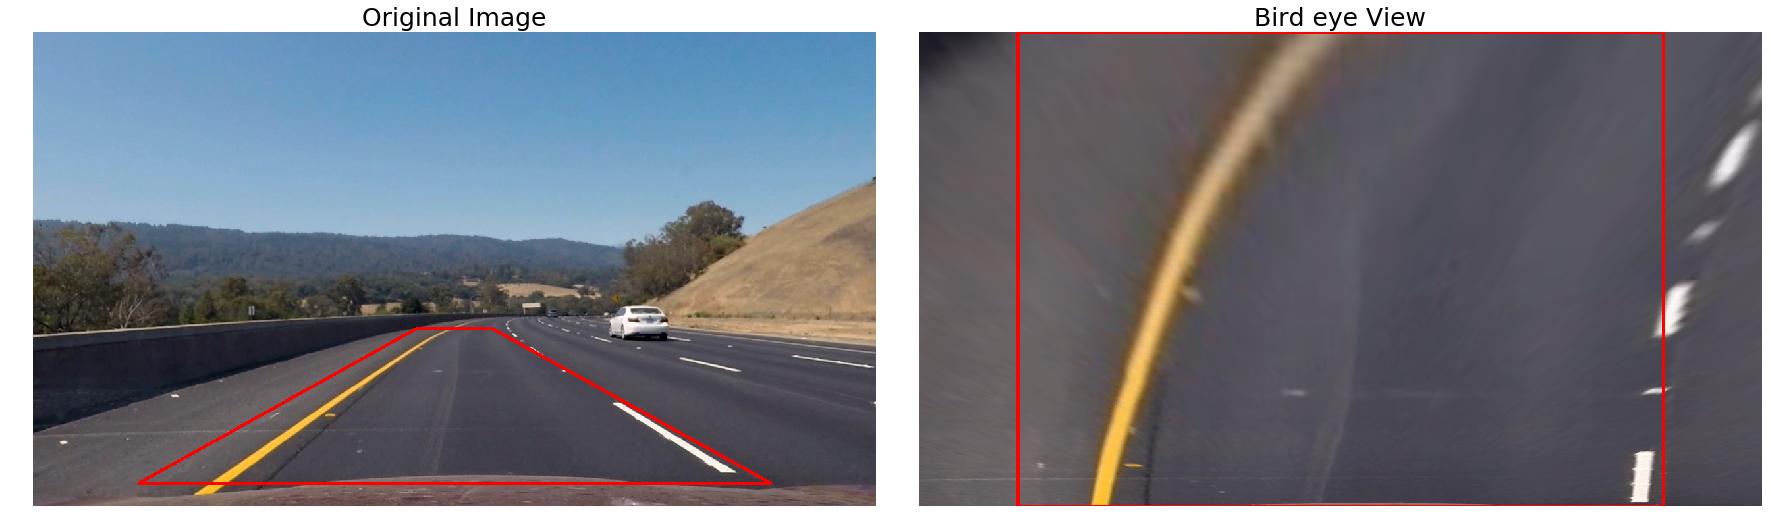

In [9]:
# Apply perspective transform to get Bird-Eye-View
# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

# undistort image
image = cal_undistort(image, objpoints, imgpoints)

warped, M_warp, M_inv_warp = warp_image(image, points_src_float, points_dst_float)
cv2.polylines(image, [points_src_arr], True, color = (255,0,0), thickness = 3)
cv2.polylines(warped, [points_dst_arr], True, color = (255,0,0), thickness = 3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped)
ax2.axis('off')
ax2.set_title('Bird eye View', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

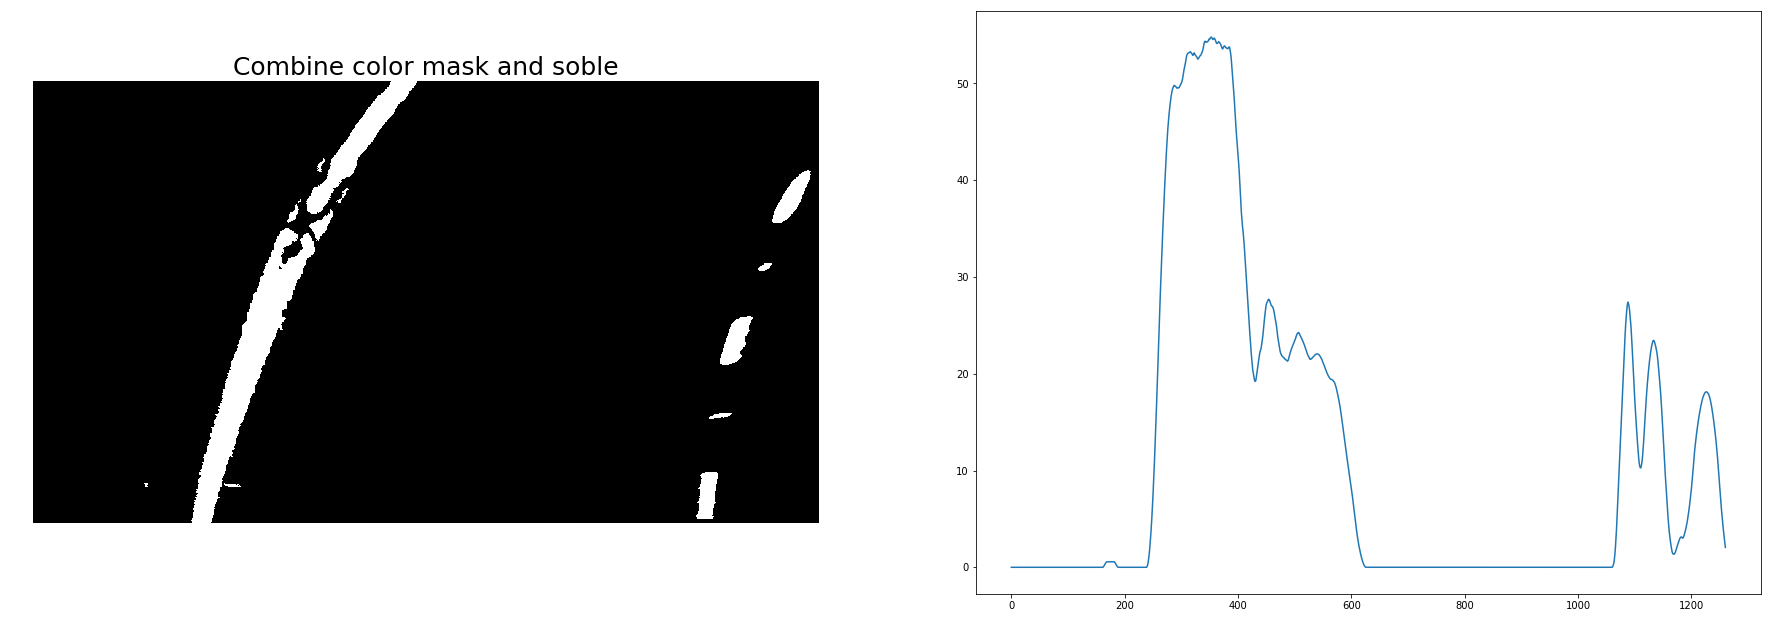

In [10]:
# Find lanes

def get_moving_average(data, N):
    mov_avg = np.convolve(data, np.ones((N,))/N, mode='valid')
    return mov_avg

# Combine Color mask (white and yellow) and sobel filters
# read in one test image 
#image = mpimg.imread('test_images/straight_lines2.jpg')
image = mpimg.imread('test_images/test3.jpg')

# undistort image
image = cal_undistort(image, objpoints, imgpoints)
warped, M_warp, M_inv_warp = warp_image(image, points_src_float, points_dst_float)

mask_yellow_white = get_color_mask(warped)

filter_hls_l, filter_hls_s = get_sobel_mask(warped)
filter_hls_l_s = cv2.bitwise_or(filter_hls_l,filter_hls_s)

image_filter_comb = cv2.bitwise_or(filter_hls_l_s, mask_yellow_white)

mean_of_lane = np.mean(image_filter_comb, axis=0)
mean_of_lane = get_moving_average(mean_of_lane, 20)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image_filter_comb, cmap='gray')   
ax1.axis('off')
ax1.set_title('Combine color mask and soble', fontsize=25)
ax2.plot(mean_of_lane)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

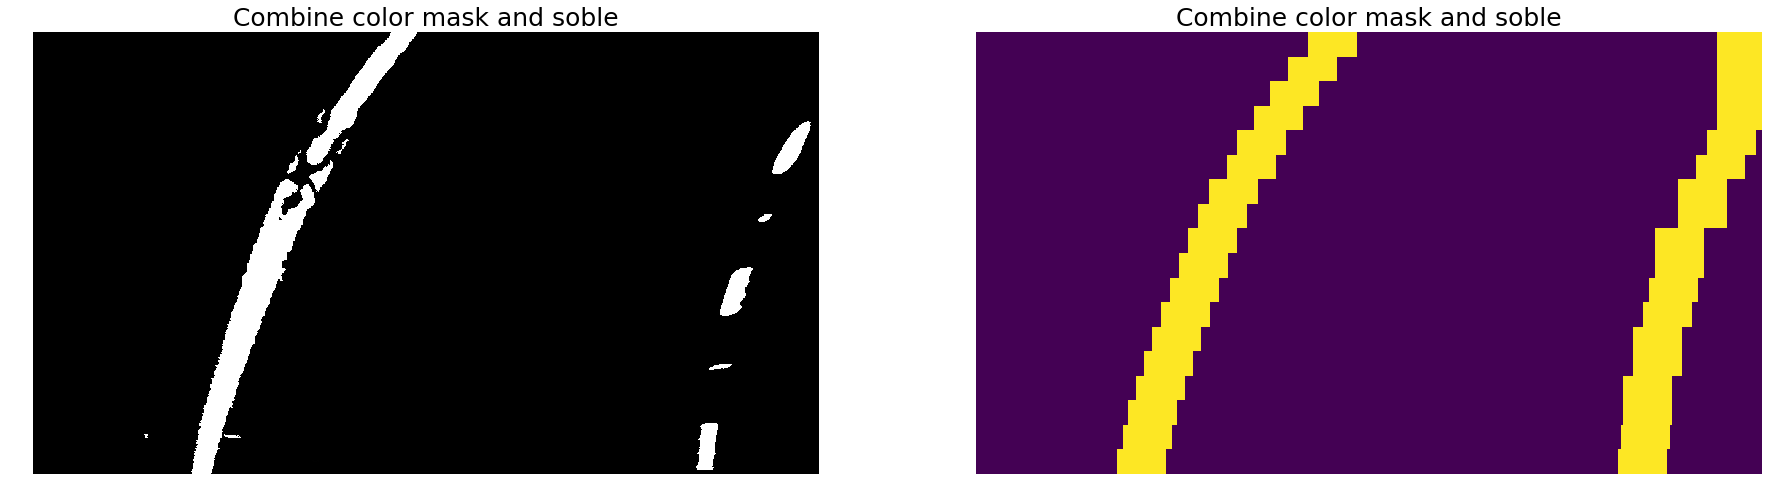

In [23]:
# Find lines
from scipy.signal import find_peaks_cwt

def get_first_mask(image,size_window):
    numer_boxes = int(image_size[0] / size_window)
    for i in range(numer_boxes):
        if i == 0: # TODO get rid of this
            indexes = find_peaks_cwt(mean_of_lane, np.arange(80,100))
            index_peak_left = indexes[0]
            index_peak_right = indexes[1]
            mask_left = np.zeros_like(image_filter_comb)
            mask_right = np.zeros_like(image_filter_comb)
            index_peak_right_last = index_peak_right
            index_peak_left_last = index_peak_left

        box_y_bottom = image_size[0] - i * size_window
        box_y_top = image_size[0] - (i+1) * size_window

        mean_lane_y = np.mean(image_filter_comb[box_y_top:box_y_bottom,:],axis=0)
        mean_lane_y = get_moving_average(mean_lane_y,20)
        indexes = find_peaks_cwt(mean_lane_y, np.arange(80,100))

        # No peak found
        if len(indexes) == 0:
            index_peak_left = index_peak_left_last
            index_peak_right = index_peak_right_last
        # Only one peak found
        elif len(indexes) == 1:
            # Decide which was has the best fit out of the last stored
            diff_peak_left = np.abs(indexes[0] - index_peak_left_last)
            diff_peak_right = np.abs(indexes[0] - index_peak_right_last)
            if  diff_peak_left < diff_peak_right:
                index_peak_left = indexes[0]
                index_peak_right = index_peak_right_last
            else: 
                index_peak_right = indexes[0]
                index_peak_left = index_peak_left_last
        # Two peaks found
        else:
            index_peak_left = indexes[0]
            index_peak_right = indexes[1]

        # Take old data if the difference is to high       
        max_diff = 110            
        left_diff = np.abs(index_peak_left - index_peak_left_last)
        right_diff = np.abs(index_peak_right - index_peak_right_last)
        if  left_diff >= max_diff:
            index_peak_left = index_peak_left_last
        if  right_diff >= max_diff:
            index_peak_right = index_peak_right_last

        mask_left[box_y_top:box_y_bottom,index_peak_left-size_window:index_peak_left+size_window] = 1     
        mask_right[box_y_top:box_y_bottom,index_peak_right-size_window:index_peak_right+size_window] = 1 

        index_peak_left_last = index_peak_left
        index_peak_right_last = index_peak_right
    
    return mask_left, mask_right

mask_left, mask_right = get_first_mask(image_filter_comb,40)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image_filter_comb, cmap='gray')   
ax1.axis('off')
ax1.set_title('Combine color mask and soble', fontsize=25)
ax2.imshow(mask_left + mask_right)
ax2.axis('off')
ax2.set_title('Combine color mask and soble', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

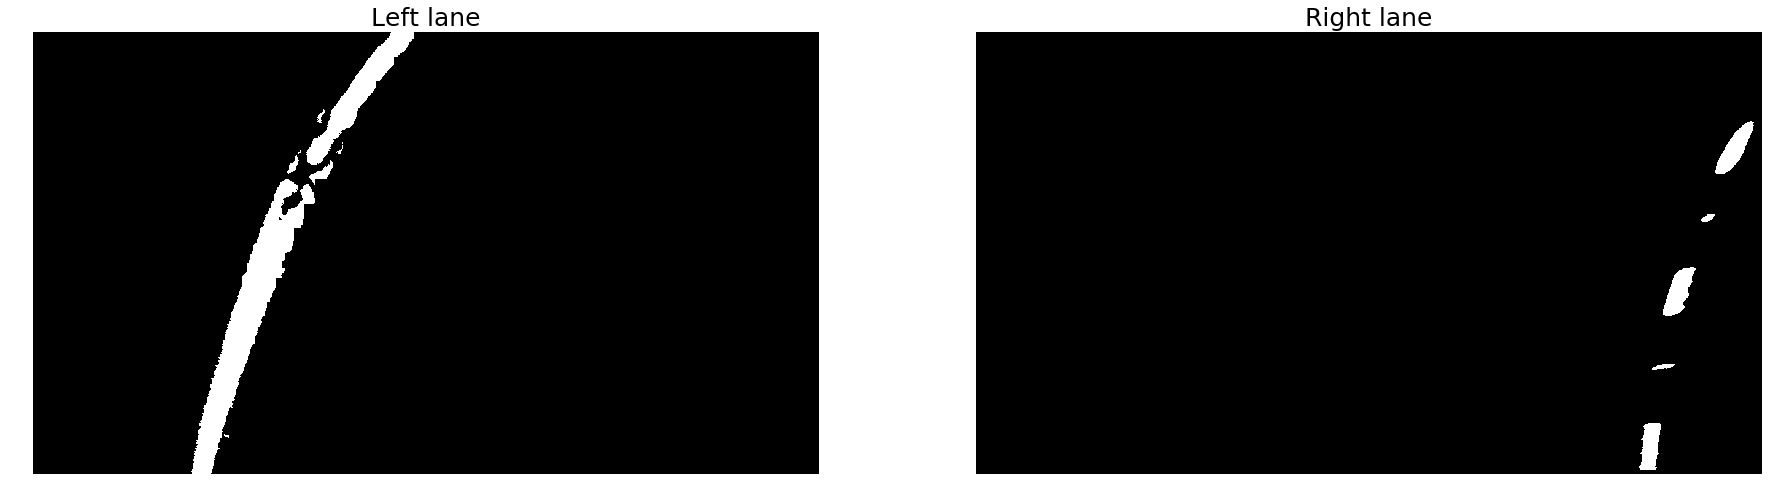

In [25]:
# Get left and right lane seperately
image_left_copy = np.copy(image_filter_comb)
image_left_copy = cv2.bitwise_and(image_left_copy, image_left_copy, mask = mask_left)

image_right_copy = np.copy(image_filter_comb)
image_right_copy = cv2.bitwise_and(image_right_copy,image_right_copy, mask = mask_right)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image_left_copy, cmap='gray')   
ax1.axis('off')
ax1.set_title('Left lane', fontsize=25)
ax2.imshow(image_right_copy, cmap='gray')
ax2.axis('off')
ax2.set_title('Right lane', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [15]:
# Import everything needed to edit/save/watch video clips
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    result = modify_img(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [17]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:18<00:00, 14.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.94 s, sys: 1.49 s, total: 5.43 s
Wall time: 21.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:59<00:00, 11.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12 s, sys: 4.64 s, total: 16.7 s
Wall time: 1min


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

* My line detection software:
 * The written programm can produce annotated pictures (in the test_images folder) and annoted videos. It is working   quite well for the two mandatory videos and for the addtional challenge video too. Anyway it's not perfect. There are still some improvments for further work.

 * The programm can be configured if there shall be additional debug output, if the test pictures in the specific folder shall be annoted and finally if the raw hough lines shall be shown or the extrapolated lines. To do this, please modify the parameters in the configuration area at the beginning of the code.


* The pipeline itself:
 * Convert the picture (frame) into a gray colored one. At this step a first filter is used bei only showing regions  in the range between 196 and 255.
 * Use a Gausssian-Blur on the gray image with kernel-size 5 (because this has shown the best results)
 * Apply the Canny-algorithm with a low-threshold of 100 and a high-threshold of 200
 * Apply a region of interest to mask out everything what is outside of the actual used driving lane. The size of the region is automatically adjusted to the size of the picture (frame)
 * Do a hough transformation with the following parameters: rho = 1, theta = np.pi/180, threshold = 15,    min_line_length = 20 and max_line_gap = 10
 * Create a weighted image (frame) with the following parameters: α=0.8, β=1. and λ=0.
 * Final image (frame) available
 
* Optimizations that have been implemented
 * First filter directly on the gray-scaled image
 * Minimization of fluttering by averaging between two frames
 * Filtering out of horizontal lines through boundaries of the slopes (between +/-0.8 and +/-0.4)
 * Starting values for x/y-values depending on framesize
 * Region of interest depending on framesize
 
* Shortcomings
 * Annotated lines are still fluttering especially when the road is gray (in different shades)
 
* Further improvements
 * Use transformation into HSV-Color-Space and apply filtering for yellow and white segments. This was working quite well for yellow lines, but not for white (light-gray) ones.
 * Optimize the parameters all over the pipeline
 * Check the solutions with further training/test data.
 * Do not directly use global variables for connecting the data from two frames, because this is not a good programming style (write access form inside a function).
 
Thats all. The project was really fun. I am looking forward to the next ones.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [21]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:45<00:00,  7.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.68 s, sys: 3.23 s, total: 10.9 s
Wall time: 50.1 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))